# Setting up the Folders and Packages

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 90% 54.0M/60.3M [00:00<00:00, 130MB/s] 
100% 60.3M/60.3M [00:00<00:00, 121MB/s]


In [ ]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [ ]:
# Define your project name
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

base_dir = '/content'
os.makedirs(os.path.join(base_dir, project_name),exist_ok=True)
for model_name in model_names:
    os.makedirs(os.path.join(base_dir, project_name, model_name),exist_ok=True)

In [ ]:
emotions=os.listdir('/content/train/')

In [ ]:
emotions_count={}
for emotion in emotions:
  emotions_count[emotion]=len(os.listdir('/content/train/'+emotion))

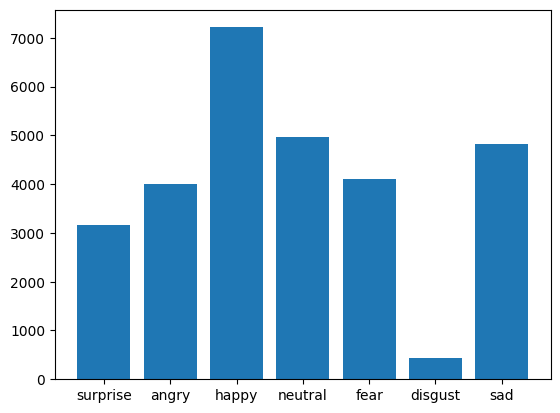

In [ ]:
plt.bar(emotions_count.keys(),emotions_count.values())
plt.show()

# Data Cleaning

In [ ]:
import imghdr
image_exts = ['jpeg','jpg','png']

for dir_path,folders,files in os.walk('/content/train'):
  for file in files:
    try:
      if imghdr.what(os.path.join(dir_path,file)) not in image_exts:
        print(f"Remving file {file}")
        os.remove(os.path.join(dir_path,file))
    except Exception as e:
      print(f"Error in {file}: {e}")
      os.remove(os.path.join(dir_path,file))


# Data Analysis

In [ ]:
def count_files_in_directory(directory,set_name):
    counts = {}
    for dir_path,folders,files in os.walk(directory):
      for folder in folders:
        counts[folder]=len(os.listdir(os.path.join(dir_path,folder)))

    df = pd.DataFrame(counts,index=[set_name])
    return df

In [ ]:
df_train=count_files_in_directory('/content/train','train')
df_test=count_files_in_directory('/content/test','test')
print(df_train)
print(df_test)

       surprise  angry  happy  neutral  fear  disgust   sad
train      3171   3995   7215     4965  4097      436  4830
      surprise  angry  happy  neutral  fear  disgust   sad
test       831    958   1774     1233  1024      111  1247


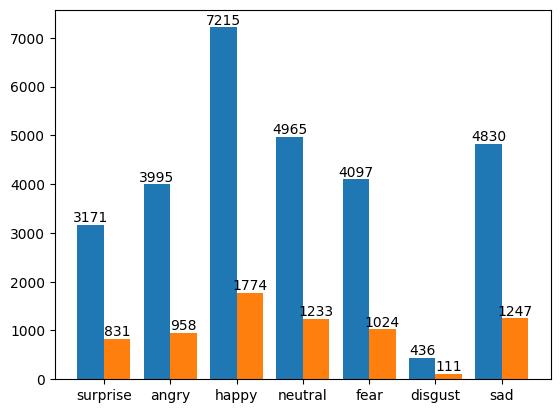

In [ ]:
fig,ax=plt.subplots()
#don't pass in any parameters just for a single plot
X=np.arange(len(df_train.columns))
b1=ax.bar(X-0.2,df_train.iloc[0],width=0.4)
b2=ax.bar(X+0.2,df_test.iloc[0],width=0.4)
ax.bar_label(b1)
ax.bar_label(b2)
ax.set_xticks(X,df_train.columns)
plt.show()
# This is how we can adjust the widths and shift the X coordinates
# and then manually set x labels
# As we can see there is a class imbalance
# 'disgust' class has very less images

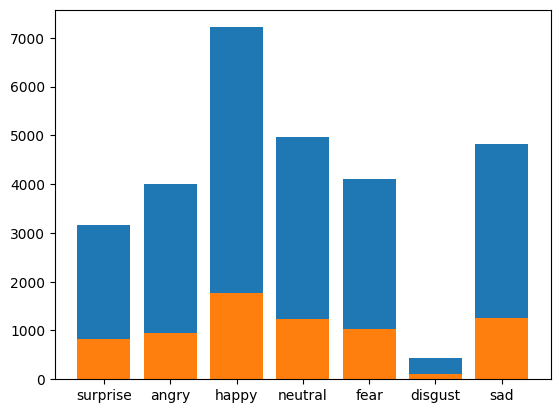

In [ ]:
plt.bar(df_train.columns,df_train.iloc[0])
plt.bar(df_test.columns,df_test.iloc[0])
plt.show()

# Plotting a single image from each emotion

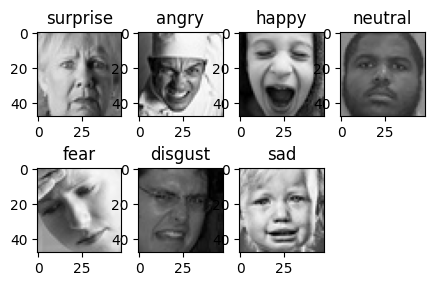

In [ ]:
train_dir = '/content/train'
plt.figure(figsize=(5,5))
for dir_path,folders,files in os.walk(train_dir):
  for i,folder in enumerate(folders):
    r=random.choice(os.listdir(os.path.join(dir_path,folder)))
    img = load_img(os.path.join(dir_path,folder)+'/'+r)
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(folder)

plt.show()

(48, 48, 1)


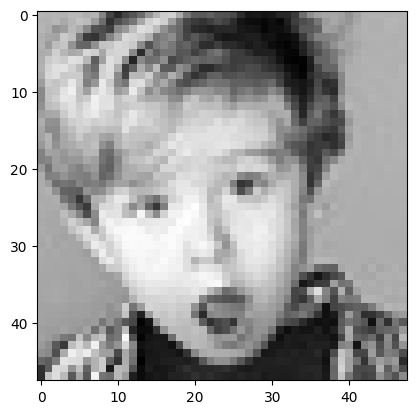

In [ ]:
img = load_img('/content/train/surprise/Training_10028230.jpg',target_size=(48,48),color_mode='grayscale')
print(img_to_array(img).shape)
plt.imshow(img,cmap='gray')
plt.show()
# the target_size attribute of load_image just redivides the image into given number of pixels
# if you want to make the image appear bigger then use figsize as shown above
# Also notice that by default load_img loads the images in RGB i.e. 3 channels but we know we have grayscale images
# so load the images in grayscale to avoid duplication of values

# Model 1: Custom CNN from Scratch

### Initialising the Image Generators

In [ ]:
num_classes= 7
test_dir = '/content/test'
train_dir = '/content/train'
img_width,img_height = 48,48
batch_size = 64
epochs = 10

In [ ]:
data_gen = ImageDataGenerator(rescale=1/255,validation_split=0.2)

In [ ]:
train_generator=data_gen.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'
)
validation_generator=data_gen.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'
)
test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_class_labels = train_generator.class_indices
print(train_class_labels)
test_class_labels = test_generator.class_indices
print(test_class_labels)
validation_class_labels = validation_generator.class_indices
print(validation_class_labels)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Batch normalization helps prevent overfitting and speeds up training of deep neural networks
# It normalizes activations of each layer by subtracting mean and dividing by standard deviation
# Rescaling and offsetting is done using learnable parameters gamma and beta
# Batch normalization handles internal covariate shift and smoothens the loss landscape
# Dropout makes 25% of the values randomly to 0
# This we do to avoid duplicate information

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

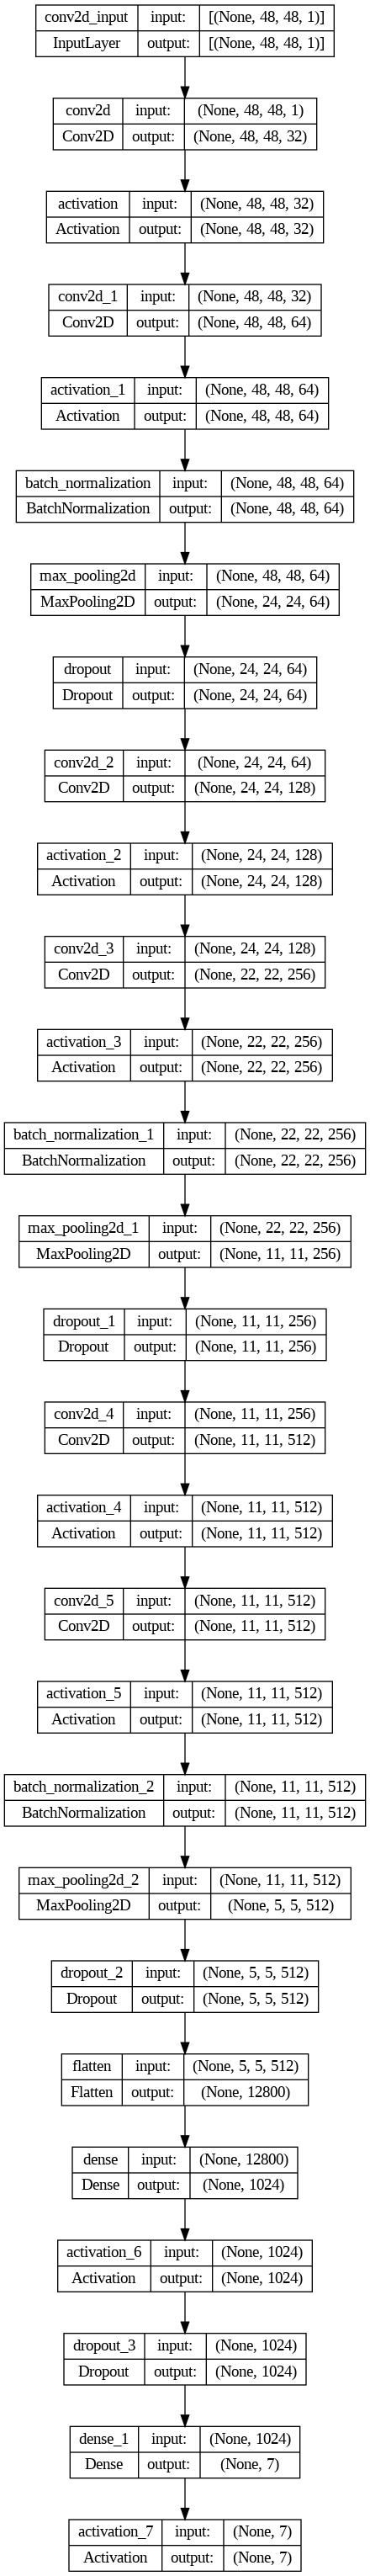

In [ ]:
plot_model(model, to_file='/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png', show_shapes=True,show_layer_names=True)

# Understanding Callbacks

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [ ]:
# Callback to save the model checkpoint
# verbose is basically it will output the update msgs when set to 1 else it operates in quiet mode
# when val_loss decreases it saves that checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [ ]:
# Callback for early stopping
# min_delta is that the validation loss should decrease atleast by 0
# if it does not decrease or increase for patience number of epochs then training is stopped
# and best weights are restored
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [ ]:
# Callback to reduce learning rate
# Reduce learning rate when val_loss is not improving by atleast min_delta amount
# for patience number of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [ ]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [ ]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

# Calculating Steps for Epoch

In [ ]:
train_generator.samples

22968

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
print(train_steps_per_epoch)
validation_steps_per_epoch = validation_generator.samples // validation_generator.batch_size + 1
print(validation_steps_per_epoch)
test_steps_per_epoch = test_generator.samples // test_generator.batch_size + 1
print(test_steps_per_epoch)

359
90
113


# Training

In [ ]:
train_generator.reset()
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_per_epoch,
    callbacks=callbacks
)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.4238 - accuracy: 0.2729
Epoch 1: val_loss improved from inf to 14.95852, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 39s 78ms/step - loss: 12.4238 - accuracy: 0.2729 - val_loss: 14.9585 - val_accuracy: 0.1012 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 10.2283 - accuracy: 0.3559
Epoch 2: val_loss improved from 14.95852 to 9.45467, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 27s 75ms/step - loss: 10.2283 - accuracy: 0.3559 - val_loss: 9.4547 - val_accuracy: 0.3978 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 8.2091 - accuracy: 0.4042
Epoch 3: val_loss improved from 9.45467 to 7.33499, saving model to /content/FER_2013_Emotion_Detection/Cus

# Plotting Performance Metrics

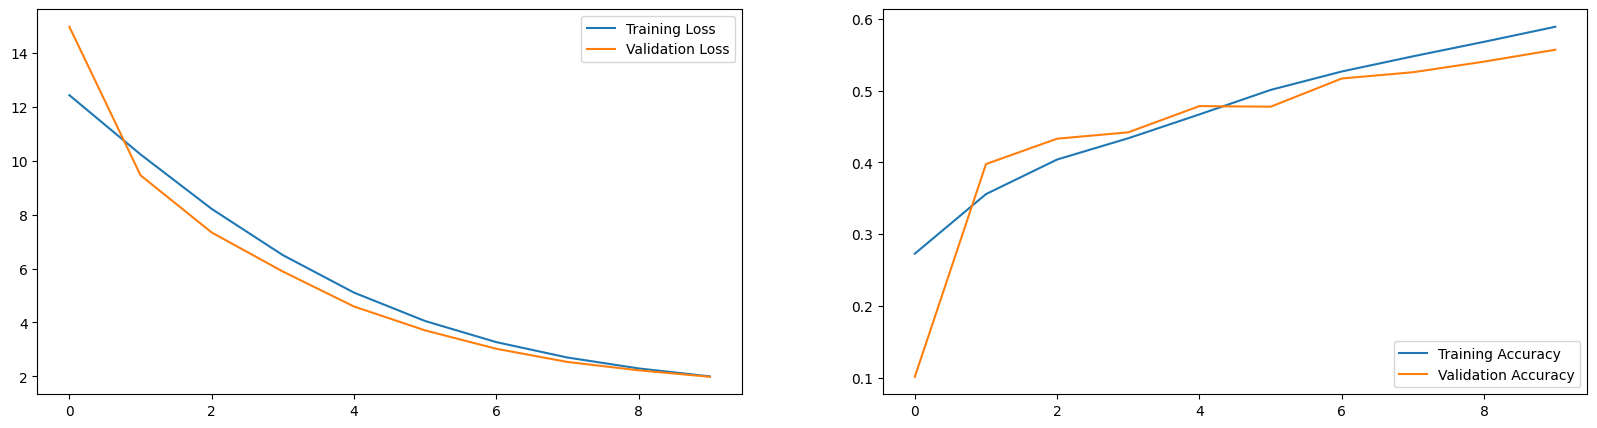

In [ ]:
train_loss=history.history['loss']
train_acc=history.history['accuracy']
val_loss=history.history['val_loss']
val_acc=history.history['val_accuracy']
epoch_range = np.arange(epochs)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(epoch_range,train_loss,label='Training Loss')
plt.plot(epoch_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(epoch_range,train_acc,label='Training Accuracy')
plt.plot(epoch_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 30ms/step - loss: 1.9814 - accuracy: 0.5631
final train accuracy = 63.71 , validation accuracy = 56.31


In [ ]:
true_classes = test_generator.classes
predicted_classes = model.predict(test_generator)
print(predicted_classes.shape)


113/113 [==============================] - 2s 20ms/step
(7178, 7)


In [ ]:
predicted_classes= np.argmax(predicted_classes, axis=1)
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

[[ 53  13  94 258 268 170 102]
 [  4   0   7  34  34  21  11]
 [ 62  12 106 283 252 199 110]
 [ 98  18 175 496 454 335 198]
 [ 79  10 128 352 299 237 128]
 [ 71  17 107 338 355 230 129]
 [ 38  10  90 245 202 154  92]]


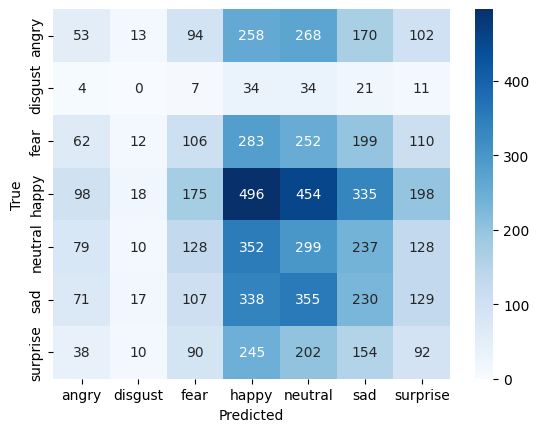

In [ ]:
class_labels = test_generator.class_indices
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels.keys(),yticklabels=class_labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# We can see model is performing very bad due to class imbalance
# maybe architecture is not good
# So we will use pre trained models in the next section

In [ ]:
report=classification_report(true_classes, predicted_classes,target_names=class_labels.keys())
print(report)

              precision    recall  f1-score   support

       angry       0.13      0.06      0.08       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.10      0.12      1024
       happy       0.25      0.28      0.26      1774
     neutral       0.16      0.24      0.19      1233
         sad       0.17      0.18      0.18      1247
    surprise       0.12      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



In [ ]:
print(len(test_generator))
print(true_classes.shape)

113
(7178,)


47
[49, 6, 60, 2, 61, 54, 37, 56, 12, 17]


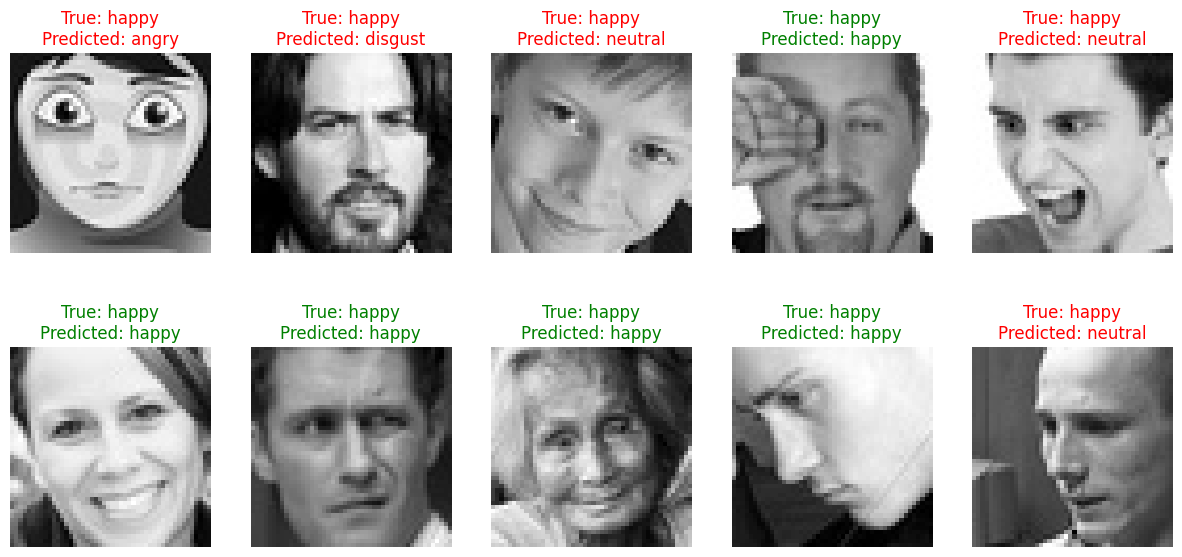

In [ ]:
Emotion_classes = list(test_generator.class_indices.keys())

Random_batch = random.choice(list(range(0,len(test_generator)-1)))
#last_batch has less images that's why excluding that
print(Random_batch)
Random_img_indices = random.choices(list(range(0,batch_size)),k=10)
print(Random_img_indices)

fig,ax = plt.subplots(2,5,figsize=(15,7))
ax = ax.ravel()

for i,idx in enumerate(Random_img_indices):
  img = test_generator[Random_batch][0][idx]
  True_label = Emotion_classes[true_classes[Random_batch*batch_size+idx]]
  Predicted_label = Emotion_classes[predicted_classes[Random_batch*batch_size+idx]]
  ax[i].imshow(img,cmap='gray')
  color = 'green' if True_label == Predicted_label else 'red'
  ax[i].set_title(f"True: {True_label}\nPredicted: {Predicted_label}",color=color)
  ax[i].axis('off')
plt.show()

# Image Augmentation

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

epochs=10
num_classes=7
img_width,img_height = 48,48
batch_size = 64

# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1/255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1/255)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


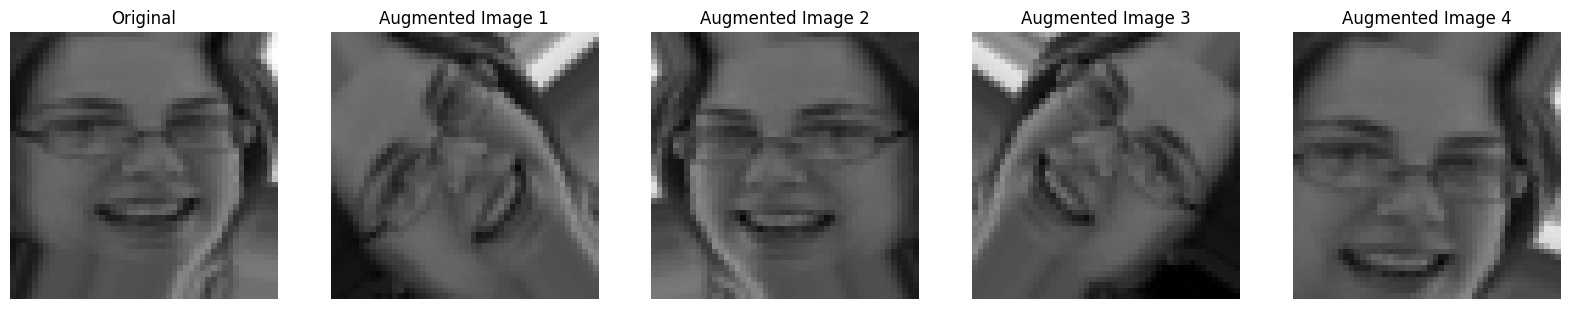

In [ ]:
image_path = '/content/train/happy/Training_10019449.jpg'
img_array = load_img(image_path)
img_array = img_to_array(img_array)
img_array = np.expand_dims(img_array, axis=0)


fig,ax = plt.subplots(1,5,figsize=(20,5))
ax=ax.flatten()

aug_iter=data_generator.flow(img_array)
for i in range(5):
  img=next(aug_iter)[0]
  ax[i].imshow(img,cmap='gray')
  ax[i].axis('off')
  title = 'Original' if i==0 else f'Augmented Image {i}'
  ax[i].set_title(title)
plt.show()

#This is how augmented images will be added to provide more data artificially while flowing/training

In [ ]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

# If I want to reset the weights then I have to create a new instance mere compiling again would not help

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.5332 - accuracy: 0.2161
Epoch 1: val_loss improved from inf to 11.86574, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 33s 83ms/step - loss: 12.5332 - accuracy: 0.2161 - val_loss: 11.8657 - val_accuracy: 0.2076 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 10.2687 - accuracy: 0.2379
Epoch 2: val_loss improved from 11.86574 to 10.03014, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 31s 85ms/step - loss: 10.2687 - accuracy: 0.2379 - val_loss: 10.0301 - val_accuracy: 0.2644 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 8.1911 - accuracy: 0.2459
Epoch 3: val_loss improved from 10.03014 to 7.34959, saving model to /conte

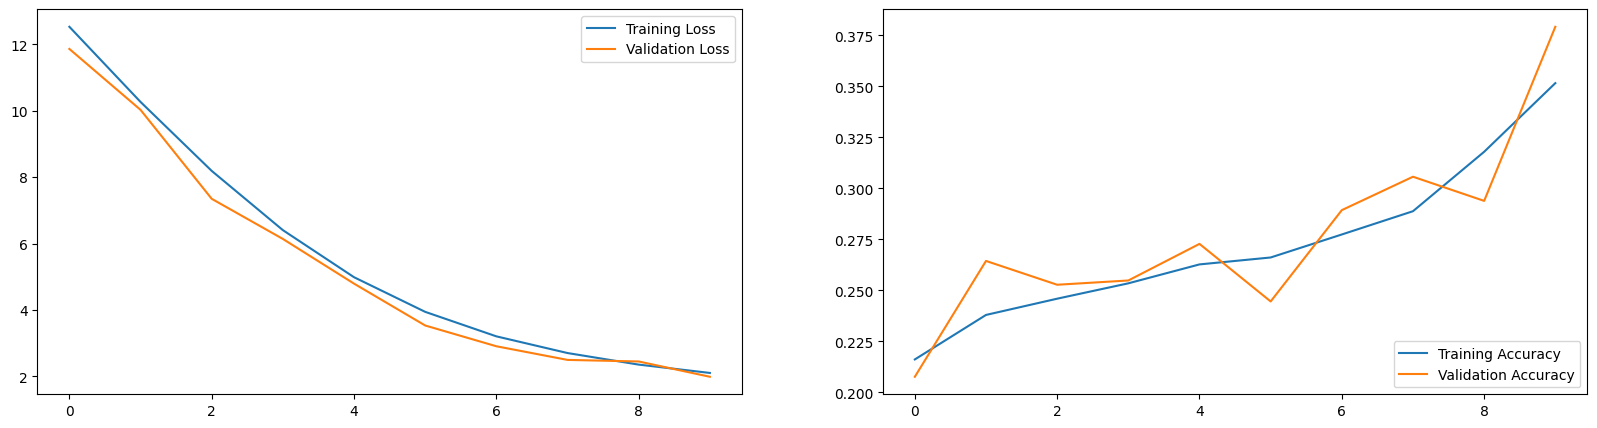

In [ ]:
train_loss=history.history['loss']
train_acc=history.history['accuracy']
val_loss=history.history['val_loss']
val_acc=history.history['val_accuracy']
epoch_range = np.arange(epochs)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(epoch_range,train_loss,label='Training Loss')
plt.plot(epoch_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(epoch_range,train_acc,label='Training Accuracy')
plt.plot(epoch_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 24ms/step - loss: 1.9262 - accuracy: 0.4115
final train accuracy = 38.14 , validation accuracy = 41.15


In [ ]:
true_classes = test_generator.classes
predicted_classes = model.predict(test_generator)
print(predicted_classes.shape)


113/113 [==============================] - 3s 26ms/step
(7178, 7)


In [ ]:
predicted_classes= np.argmax(predicted_classes, axis=1)
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

[[ 31   0  72 267 253  76 259]
 [  4   0   6  23  31  13  34]
 [ 40   0  81 274 246  80 303]
 [ 47   0 134 494 424 141 534]
 [ 28   0 101 337 281 110 376]
 [ 33   0  90 347 263 107 407]
 [ 22   0  66 232 194  61 256]]


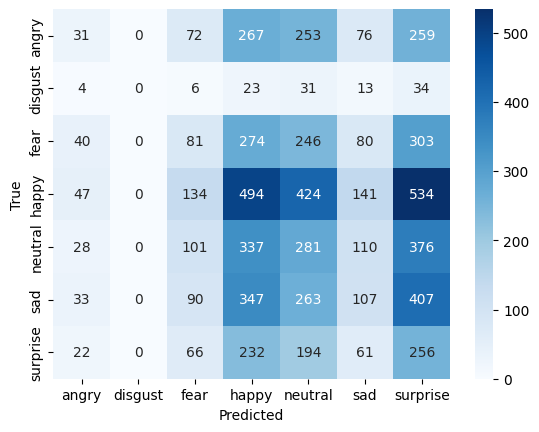

In [ ]:
class_labels = test_generator.class_indices
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels.keys(),yticklabels=class_labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# We can see model is performing very bad due to class imbalance
# maybe architecture is not good
# So we will use pre trained models in the next section

In [ ]:
report=classification_report(true_classes, predicted_classes,target_names=class_labels.keys())
print(report)

              precision    recall  f1-score   support

       angry       0.15      0.03      0.05       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.08      0.10      1024
       happy       0.25      0.28      0.26      1774
     neutral       0.17      0.23      0.19      1233
         sad       0.18      0.09      0.12      1247
    surprise       0.12      0.31      0.17       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.18      0.17      0.16      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Transfer Learning using VGGNet

In [2]:
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [3]:
train_dir = '/content/train'
test_dir = '/content/test'
img_width,img_height=224,224
# as of ImageNet dataset
num_classes=7
batch_size=64
epochs=10

data_generator=ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_data_generator=ImageDataGenerator(rescale=1/255)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset='training'
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
classes = np.array(train_generator.classes)

class_weights=compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights=dict(enumerate(class_weights))
class_weights

# observe that disgust(1) class has the maximum weight because it has very less images
# and happy(3) has the least weight because it has most images
# Higher weight means on making a mistake in that classes it will be corrected more aggressively

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 6: 1.293372978330405}

In [5]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [6]:
tf.keras.backend.clear_session()

vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_width,img_height,3)
)

# include_top = False means we don't want to include the dense layers just the convolution layers
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

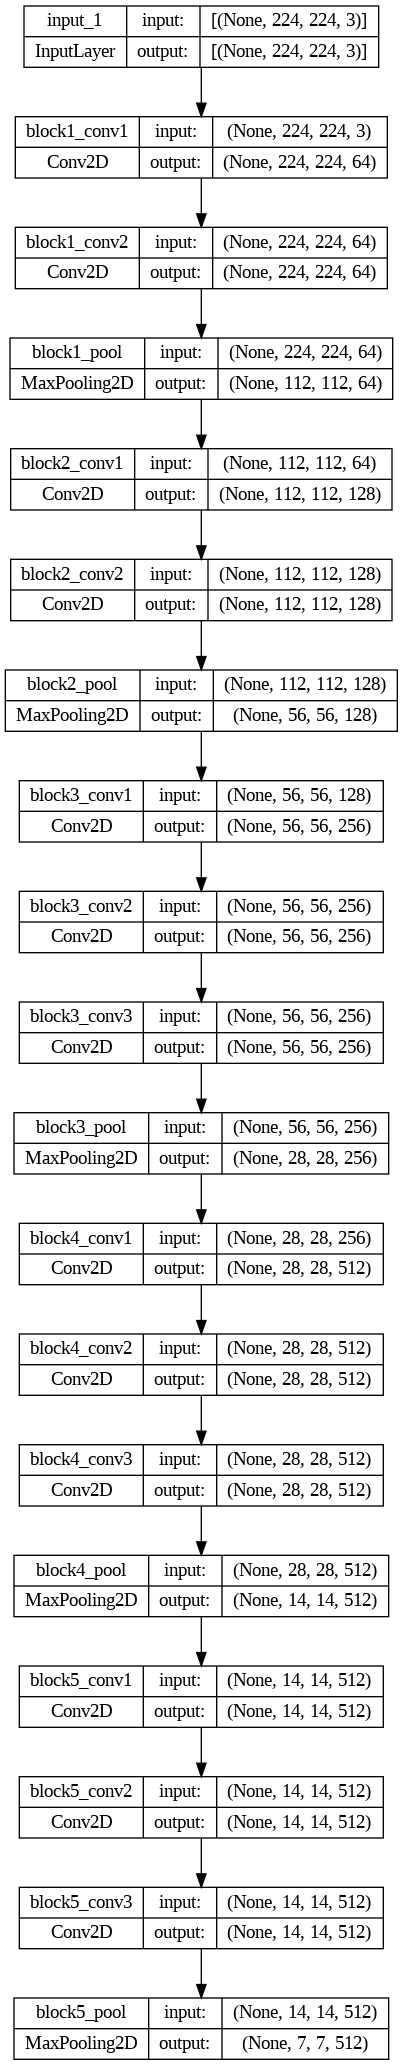

In [7]:
plot_model(vgg,show_shapes=True,show_layer_names=True)

In [8]:
for layer in vgg.layers[-4:]:
  print(layer.name)

block5_conv1
block5_conv2
block5_conv3
block5_pool


In [9]:
for layer in vgg.layers[:-3]:
  layer.trainable=False

vgg.summary()
# observe that the trainable parameters only include block5_conv2 and block5_conv3
# We discussed that we will retrain some of the last layers to fit our use case

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
x = Flatten()(vgg.output)

x = Dense(1024, activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

x = Dense(num_classes, activation='softmax',kernel_initializer='he_normal')(x)

model = Model(inputs=vgg.input, outputs=x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,amsgrad=False),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    callbacks=callbacks,
    class_weight=class_weights,
    validation_data=test_generator,
    validation_steps=test_steps_epoch
)

Epoch 1/10
 12/449 [..............................] - ETA: 6:12 - loss: 2.5464 - accuracy: 0.1432

KeyboardInterrupt: 

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

# Transfer Learning using ResNet50

In [14]:
train_dir = '/content/train'
test_dir = '/content/test'
img_width,img_height=224,224
# as of ImageNet dataset
num_classes=7
batch_size=64
epochs=10

data_generator=ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_data_generator=ImageDataGenerator(rescale=1/255)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset='training'
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [15]:
classes = np.array(train_generator.classes)

class_weights=compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights=dict(enumerate(class_weights))
class_weights

# observe that disgust(1) class has the maximum weight because it has very less images
# and happy(3) has the least weight because it has most images
# Higher weight means on making a mistake in that classes it will be corrected more aggressively

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 6: 1.293372978330405}

In [16]:
ResNet50V2 = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

94668760/94668760 [==============================] - 1s 0us/step


In [17]:
len(ResNet50V2.layers)

190

In [18]:
len(vgg.layers)

19

In [19]:
ResNet50V2.trainable=True

for layer in ResNet50V2.layers[:-50]:
  layer.trainable=False

# Only the last 50 layers will be trainable

In [20]:
model = Sequential([
    ResNet50V2,
    Dropout(0.25),
    BatchNormalization(),
    Flatten(),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [21]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [23]:
train_history = model.fit(
    train_generator,
    batch_size=batch_size,
    epochs=30,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=test_generator,
    validation_steps=test_steps_epoch,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.8836 - accuracy: 0.3558
Epoch 1: val_loss improved from inf to 4.67304, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 423s 905ms/step - loss: 1.8836 - accuracy: 0.3558 - val_loss: 4.6730 - val_accuracy: 0.4126 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.5644 - accuracy: 0.4604
Epoch 2: val_loss improved from 4.67304 to 2.06645, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 399s 888ms/step - loss: 1.5644 - accuracy: 0.4604 - val_loss: 2.0664 - val_accuracy: 0.4877 - lr: 0.0010
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 1.4010 - accuracy: 0.4964
Epoch 3: val_loss improved from 2.06645 to 1.81381, saving model to /content/FER_2013_Emotio

In [ ]:
# model.save('path')
# model=keras.saving.load_model('path')
# This is how we save and load models
# after we load just call model.fit again it will resume from where it left
# we can also mount our google drive in this notebook and save and load models there

In [2]:
pip install tensorflow

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:001.4 MB/s eta 0:00:01
  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 MB 10.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 27.9 MB/s eta 0:00:0031m30.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 18.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.8 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 18.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import keras
model = keras.saving.load_model('Final_Resnet50_Best_model.keras')

ModuleNotFoundError: No module named 'tensorflow'

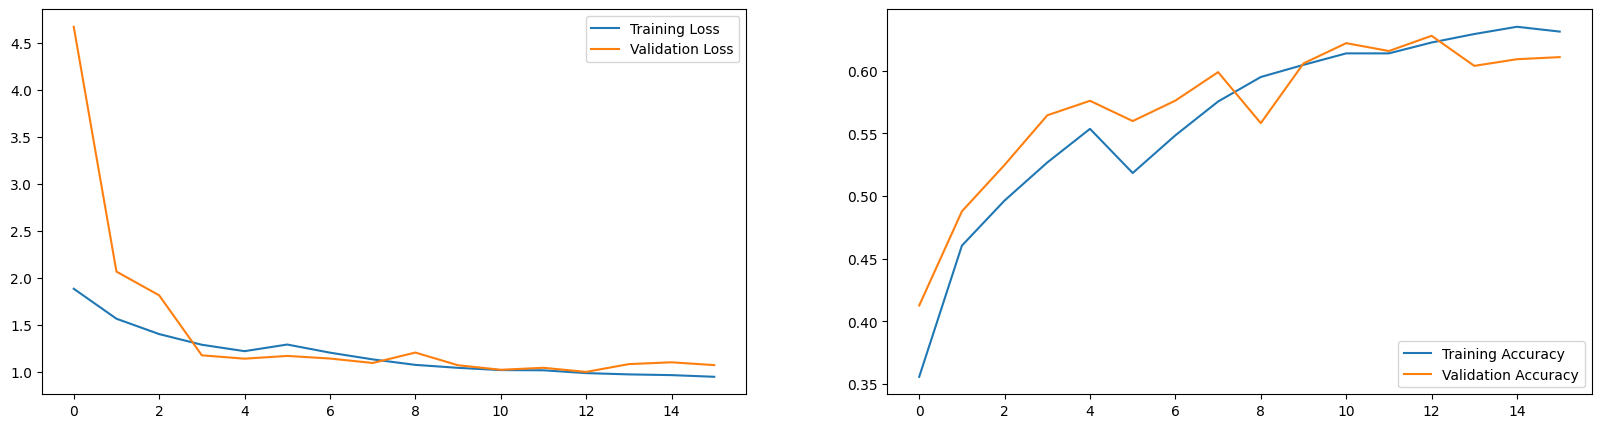

In [31]:
train_loss=train_history.history['loss']
train_acc=train_history.history['accuracy']
val_loss=train_history.history['val_loss']
val_acc=train_history.history['val_accuracy']
epoch_range = np.arange(16)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(epoch_range,train_loss,label='Training Loss')
plt.plot(epoch_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(epoch_range,train_acc,label='Training Accuracy')
plt.plot(epoch_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [25]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 21s 179ms/step - loss: 0.9982 - accuracy: 0.6278
final train accuracy = 65.42 , validation accuracy = 62.78


In [26]:
true_classes = test_generator.classes
predicted_probs = model.predict(test_generator)
print(predicted_probs.shape)
predicted_classes= np.argmax(predicted_probs, axis=1)
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

113/113 [==============================] - 21s 176ms/step
(7178, 7)
[[127  30  77 250 136 222 116]
 [ 19   3   9  29  16  22  13]
 [157  36  81 280 131 238 101]
 [244  58 138 443 285 407 199]
 [179  35  96 311 169 309 134]
 [182  38  87 307 211 273 149]
 [101  29  65 196 131 216  93]]


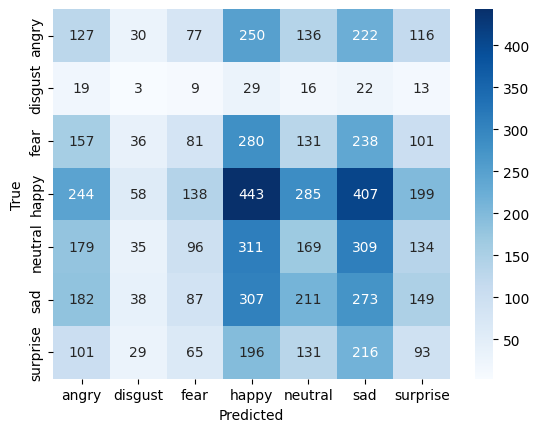

In [27]:
class_labels = test_generator.class_indices
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_labels.keys(),yticklabels=class_labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.13      0.13       958
     disgust       0.01      0.03      0.02       111
        fear       0.15      0.08      0.10      1024
       happy       0.24      0.25      0.25      1774
     neutral       0.16      0.14      0.15      1233
         sad       0.16      0.22      0.19      1247
    surprise       0.12      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.16      7178



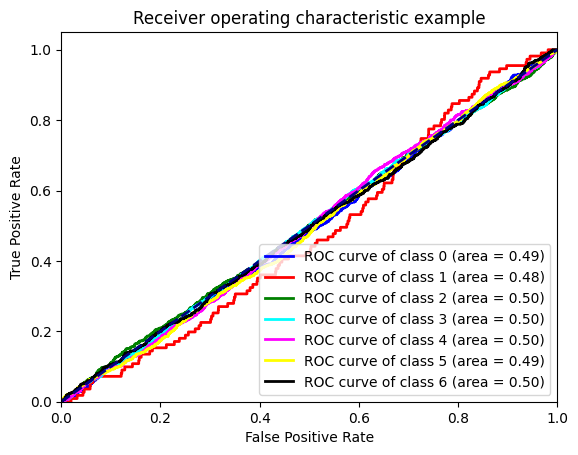

In [29]:
# prompt: plot roc curves

from sklearn.metrics import roc_curve, auc

# Assuming you have true_classes and predicted_probabilities

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(true_classes))):
    fpr[i], tpr[i], _ = roc_curve(true_classes == i, predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black']
for i, color in zip(range(len(np.unique(true_classes))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [32]:
model.save("Resnet_model_version_2.keras")